In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [21]:
!nvidia-smi

NVIDIA-SMI has failed because it couldn't communicate with the NVIDIA driver. Make sure that the latest NVIDIA driver is installed and running.



In [6]:
%matplotlib inline
import matplotlib.pyplot as plt
from __future__ import print_function
import numpy as np
import pandas as pd
import datetime, time, json
from keras.models import Model
from keras.layers import Input, TimeDistributed, Dense, Lambda, concatenate, Dropout, BatchNormalization
from keras.layers import merge
from keras.layers import Convolution1D, GlobalMaxPooling1D
from keras.layers.embeddings import Embedding
from keras.regularizers import l2
from keras.callbacks import Callback, ModelCheckpoint
from keras import backend as K
from sklearn.model_selection import train_test_split

Using TensorFlow backend.


In [0]:
PATH = 'gdrive/My Drive/quora-question-pairs/'

Q1_TRAIN = 'q1_train.npy'
Q2_TRAIN = 'q2_train.npy'
LABEL_TRAIN = 'label_train.npy'
WORD_EMBEDDING_MATRIX = 'word_embedding_matrix.npy'
NB_WORDS = 'word_index.json'
MODEL_WEIGHTS = 'question_pairs_weights.h5'
MAX_SEQ_LENGTH = 50
EMBEDDING_DIM = 300

EPOCHS = 25
BATCH_SIZE = 32

In [0]:
# Loading dataset
q1_data = np.load(open(PATH + Q1_TRAIN, 'rb'))
q2_data = np.load(open(PATH + Q2_TRAIN, 'rb'))
labels = np.load(open(PATH + LABEL_TRAIN, 'rb'))
word_embedding_matrix = np.load(open(PATH + WORD_EMBEDDING_MATRIX, 'rb'))
with open(PATH + NB_WORDS, 'r') as f:
    nb_words = json.load(f)['nb_words']

In [0]:
# Split dataset to get validation and test sets.
X = np.stack((q1_data, q2_data), axis=1)
y = labels

X_train, X_test, y_train, y_test =  train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
X_val, X_test, y_val, y_test =  train_test_split(X_test, y_test, test_size=0.5, random_state=42, stratify=y_test)

Q1_train = X_train[:,0]
Q2_train = X_train[:,1]
Q1_val = X_val[:,0]
Q2_val = X_val[:,1]
Q1_test = X_test[:,0]
Q2_test = X_test[:,1]

In [13]:
DROPOUT = 0.15

question1 = Input(shape=(MAX_SEQ_LENGTH,))
question2 = Input(shape=(MAX_SEQ_LENGTH,))

q1 = Embedding(nb_words + 1, 
                 EMBEDDING_DIM, 
                 weights=[word_embedding_matrix], 
                 input_length=MAX_SEQ_LENGTH, 
                 trainable=False)(question1)
q2 = Embedding(nb_words + 1, 
                 EMBEDDING_DIM, 
                 weights=[word_embedding_matrix], 
                 input_length=MAX_SEQ_LENGTH, 
                 trainable=False)(question2)

ConvNet = Sequential()
ConvNet.add(Convolution1D(nb_filter=64,
                         filter_length=5,
                         border_mode='valid',
                         activation='relu',
                         subsample_length=1))
ConvNet.add(Dropout(DROPOUT))
ConvNet.add(Convolution1D(nb_filter=64,
                         filter_length=5,
                         border_mode='valid',
                         activation='relu',
                         subsample_length=1))
ConvNet.add(GlobalMaxPooling1D())
ConvNet.add(Dropout(DROPOUT))
ConvNet.add(Dense(200, activation='relu'))
ConvNet.add(Dropout(DROPOUT))
ConvNet.add(BatchNormalization())


q1= ConvNet(q1)
q2= ConvNet(q2)

merged = concatenate([q1, q2])
merged = Dense(200, activation='relu')(merged)
merged = Dropout(DROPOUT)(merged)
merged = BatchNormalization()(merged)
merged = Dense(200, activation='relu')(merged)
merged = Dropout(DROPOUT)(merged)
merged = BatchNormalization()(merged)

is_duplicate = Dense(1, activation='sigmoid')(merged)

model = Model(inputs=[question1,question2], outputs=is_duplicate)
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:24: UserWarning: Update your `Conv1D` call to the Keras 2 API: `Conv1D(activation="relu", filters=64, kernel_size=5, strides=1, padding="valid")`
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:30: UserWarning: Update your `Conv1D` call to the Keras 2 API: `Conv1D(activation="relu", filters=64, kernel_size=5, strides=1, padding="valid")`


In [14]:
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 50)           0                                            
__________________________________________________________________________________________________
input_4 (InputLayer)            (None, 50)           0                                            
__________________________________________________________________________________________________
embedding_3 (Embedding)         (None, 50, 300)      24293400    input_3[0][0]                    
__________________________________________________________________________________________________
embedding_4 (Embedding)         (None, 50, 300)      24293400    input_4[0][0]                    
____________________________________________________________________________________________

In [15]:
print("Starting training at", datetime.datetime.now())
t0 = time.time()
callbacks = [ModelCheckpoint(PATH + MODEL_WEIGHTS, monitor='val_acc', save_best_only=True)]
history = model.fit([Q1_train, Q2_train], y_train,
                    epochs=EPOCHS, validation_data=([Q1_val, Q2_val], y_val),
                    verbose=2, batch_size=BATCH_SIZE, callbacks=callbacks)
t1 = time.time()
print("Training ended at", datetime.datetime.now())
print("Minutes elapsed: %f" % ((t1 - t0) / 60.))

Starting training at 2019-12-11 14:15:07.134674


Train on 323432 samples, validate on 40429 samples
Epoch 1/25
 - 535s - loss: 0.5572 - acc: 0.7131 - val_loss: 0.4994 - val_acc: 0.7531
Epoch 2/25
 - 532s - loss: 0.5011 - acc: 0.7527 - val_loss: 0.4694 - val_acc: 0.7685
Epoch 3/25
 - 530s - loss: 0.4778 - acc: 0.7663 - val_loss: 0.4541 - val_acc: 0.7833
Epoch 4/25
 - 530s - loss: 0.4616 - acc: 0.7781 - val_loss: 0.4551 - val_acc: 0.7862
Epoch 5/25
 - 532s - loss: 0.4482 - acc: 0.7856 - val_loss: 0.4388 - val_acc: 0.7909
Epoch 6/25
 - 533s - loss: 0.4375 - acc: 0.7926 - val_loss: 0.4457 - val_acc: 0.7861
Epoch 7/25
 - 530s - loss: 0.4277 - acc: 0.7991 - val_loss: 0.4299 - val_acc: 0.7976
Epoch 8/25
 - 531s - loss: 0.4204 - acc: 0.8029 - val_loss: 0.4247 - val_acc: 0.7993
Epoch 9/25
 - 530s - loss: 0.4136 - acc: 0.8069 - val_loss: 0.4273 - val_acc: 0.7971
Epoch 10/25
 - 529s - loss: 0.4054 - acc: 0.8118 - val_loss: 0.4215 - val_acc: 0.8016
Epoch 11/25
 - 529s - loss: 0.3992 - acc: 0.8160

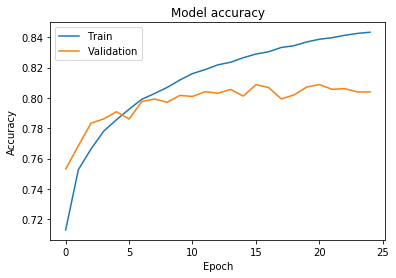

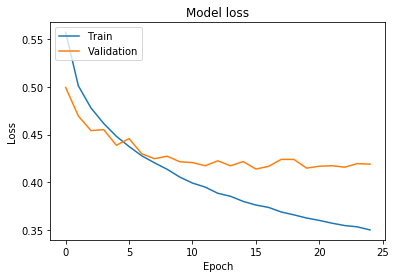

In [18]:

# Plot training & validation accuracy values
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [19]:
max_val_acc, idx = max((val, idx) for (idx, val) in enumerate(history.history['val_acc']))
print('Best accuracy at epoch', '{:d}'.format(idx+1), '=', '{:.4f}'.format(max_val_acc))

Best accuracy at epoch 21 = 0.8088


In [20]:
model.load_weights(PATH + MODEL_WEIGHTS)
loss, accuracy = model.evaluate([Q1_test, Q2_test], y_test, verbose=0)
print('Test set accuracy = {1:.4f}'.format(loss, accuracy))

Test set accuracy = 0.8058
